<u><b><h3>Rough Plan</h3></b></u>

1) Label encode the columns in the Internet Dataframe, Personal Dataframe, and Phones Dataframe. Do the same to the Contract Dataframe's 'Type', 'PaperlessBilling', and 'PaymentMethod columns. 
<br></br>
2) Fill in the Contract's 'EndDate' column with a 0 if the customer has a date (meaning they ended their subscription) or a 1 if the customer has a 'No' in this column (meaning they are still subscribed to Telecom)
<br></br>
3) Merge the dataframes with an outer join because the internet column and the phone columns do not have the same shape as the other dataframes. This is because not every customer has internet service with Telecom.
<br></br>
4) Fill in the null values in the dataframe, specifically in the internet dataframe columns.
<br></br>
5) Split the dataframe into a training, validation, and test set and tune the model to try and get a high AUC-ROC score above 75% minimum, preferably higher. Use the model with the highest AUC-ROC score to predict if a customer is going to keep subscribed with the company or is predicted to opt out of their subscription.

# Introduction

The goal is to work with Telecom data and forecast churn of their subscribing clients. If the clients are forecasted to unsubscribe from Telecom services, then our goal is for them to recieve promotional codes and special plan options to entice them to stay. 

## Importing Modules

In [1]:
pip install fast_ml

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install catboost

Note: you may need to restart the kernel to use updated packages.


In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost as xgb
from sklearn.model_selection import *
from sklearn.linear_model import *
from sklearn.tree import *
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb

from sklearn import metrics
import matplotlib.pyplot as plt
from fast_ml.model_development import train_valid_test_split

## Viewing the Dataframes

### Contract Dataframe

In [4]:
contract = pd.read_csv(r'contract.csv')

Looking at the types of data and the columns in the contract dataframe

BeginDate is going to be changed to the 'datetime' datatype. Also, the TotalCharges column needs to be changed into a 'float64' datatype

EndDate needs to be looked into before we make changes because EndDate has the string 'No' for some of the customers, therefore we cannot immediately change it to 'datetime' without taking those into account

In [5]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


While I was working on changing TotalCharges to a 'float' datatype I found that 11 of the rows in the 'TotalCharges' column have an empty string for TotalCharges 

In [7]:
contract[contract['TotalCharges'] == ' ']  

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Viewing the amount of rows in the 'TotalCharges' column that do not have empty values

In [8]:
filled_in_tc = contract[contract['TotalCharges'] != ' ']

Collecting the median total charge

In [9]:
median_total_charge = filled_in_tc['TotalCharges'].median()
print(f'The median of the total charge column is ${round(median_total_charge, 2)}')

The median of the total charge column is $1397.48


Filling in the empty strings of the 'TotalCharges' column with the median of the 'Total Charges' column. Since it is only 11 missing values this should take care of our issue while not skewing the data in one form or another.

In [10]:
contract['TotalCharges'] =  contract['TotalCharges'].replace(' ','1397.48')

Sanity Check

In [11]:
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges


Another Sanity Check

In [12]:
contract[contract['TotalCharges'] == '1397.48']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,1397.48
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,1397.48
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,1397.48
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,1397.48
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,1397.48
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,1397.48
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,1397.48
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,1397.48
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,1397.48
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,1397.48


Converting 'TotalCharges' column to a 'float' datatype

In [13]:
contract['TotalCharges'] = contract['TotalCharges'].astype('float')

Sanity Check

In [14]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


Converted BeginDate to 'datetime' datatype so that we can work with the dates

In [15]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'])

Sanity Check for BeginDate

In [16]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


Viewing missing values and concluding that there are none. 

In [17]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

There are no duplicated values in the dataframe to work with.

In [18]:
contract.duplicated().sum()

0

Viewing the first 5 rows of the contract dataframe.

In [19]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


Label Encoded the 'Type' and 'PaymentMethod' columns because they are being used in a classification task

In [20]:
contract[['Type', 'PaperlessBilling']] = contract[['Type', 'PaperlessBilling']].apply(LabelEncoder().fit_transform)
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,0,1,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,1,0,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,0,1,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,1,0,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,0,1,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,0,1,Electronic check,99.65,820.50
6,1452-KIOVK,2018-04-01,No,0,1,Credit card (automatic),89.10,1949.40
7,6713-OKOMC,2019-04-01,No,0,0,Mailed check,29.75,301.90
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,0,1,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,1,0,Bank transfer (automatic),56.15,3487.95


Created a new column of EndDate for our Machine Learning process. If EndDate has the string 'No', then the new row, which I will call 'EndDateEncoding' will have a 1 for that row. If, however, the EndDate has a date then I am going to fill the new row with a 0. This will give us a binary target with a simple 0, if the subscriber has left, or a 1 if the subscriber is still subscribed. That way we can work on our predictions towards the model.

In [21]:
contract = pd.get_dummies(contract, columns = ['PaymentMethod'])

In [22]:
contract['Target'] = np.where(contract['EndDate']=='No', 1, 0)
contract.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Target
0,7590-VHVEG,2020-01-01,No,0,1,29.85,29.85,0,0,1,0,1
1,5575-GNVDE,2017-04-01,No,1,0,56.95,1889.50,0,0,0,1,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,0,1,53.85,108.15,0,0,0,1,0
3,7795-CFOCW,2016-05-01,No,1,0,42.30,1840.75,1,0,0,0,1
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,0,1,70.70,151.65,0,0,1,0,0
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,0,1,99.65,820.50,0,0,1,0,0
6,1452-KIOVK,2018-04-01,No,0,1,89.10,1949.40,0,1,0,0,1
7,6713-OKOMC,2019-04-01,No,0,0,29.75,301.90,0,0,0,1,1
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,0,1,104.80,3046.05,0,0,1,0,0
9,6388-TABGU,2014-12-01,No,1,0,56.15,3487.95,1,0,0,0,1


### Internet Dataframe

In [23]:
internet = pd.read_csv('internet.csv')

Looking at the types of data and the columns in the internet dataframe

In [24]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [25]:
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


Viewing the missing values and duplicates and concluding that there are none

In [26]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

In [27]:
internet.duplicated().sum()

0

Viewing the first 5 rows of the internet dataframe and concluding that these columns should all be object datatypes, therefore there are no conversions that need to be done. 

In [28]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Created a bar graph to show the amount of users that use DSL vs Fiber optic

Fiber optic has more customers with more than 700 more but from a percentage standpoint Fiber optic is just over 56% of our internet service subscriptions, while DSL accounts for just under 44%. This means that both of the internet services are useful and therefore should both be advertised

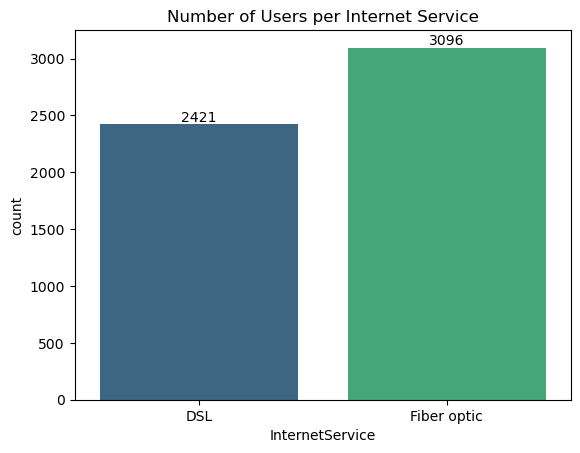

In [29]:
ax = sns.countplot(x='InternetService', data=internet, palette='viridis')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of Users per Internet Service')
    
plt.show()

In [30]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Obtaining the columns for the Label Encoding below. 

In [31]:
internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

Label encoded the 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',  and the 'StreamingMovies' columns in the internet dataframe because they are all binary categorical classifications. 

In [32]:
internet[['InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']] = internet[['InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']].apply(LabelEncoder().fit_transform)
internet.head(7)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,0,0,1,0,0,0,0
1,5575-GNVDE,0,1,0,1,0,0,0
2,3668-QPYBK,0,1,1,0,0,0,0
3,7795-CFOCW,0,1,0,1,1,0,0
4,9237-HQITU,1,0,0,0,0,0,0
5,9305-CDSKC,1,0,0,1,0,1,1
6,1452-KIOVK,1,0,1,0,0,1,0


### Personal Dataframe

In [33]:
personal = pd.read_csv('personal.csv')

Looking at the types of data and the columns in the personal dataframe

In [34]:
personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Viewing the statistics of the Senior Citizen column

In [35]:
personal.describe()

,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


Plotted a graph to compare the amount of customers by gender and then further classified them by the age being either senior citizen or not. A follow up question could definitely be at what age do people become senior citizens but for our task this is not going to matter. I'm going to assume senior citizens are between the age of 65-67 years old. 

Studying the graph shows us that almost half of our customers are male and half our female, showing that Telecom needs to be cognizant to make ads that are good for both genders.

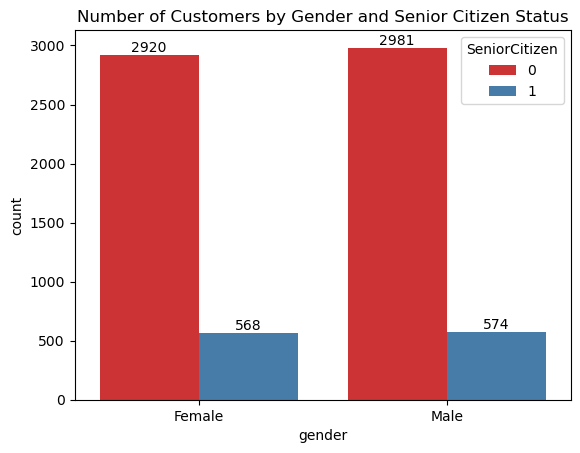

In [36]:
ax = sns.countplot(x='gender', hue='SeniorCitizen', data=personal, palette='Set1')

for label in ax.containers:
    ax.bar_label(label)

plt.title('Number of Customers by Gender and Senior Citizen Status')
    
plt.show()

Viewing the missing values and duplicates and concluding that there are none

In [37]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [38]:
personal.duplicated().sum()

0

Viewing the first 5 rows of the personal dataframe and concluding that these columns should all be object datatypes except for the 'SeniorCitizen' column, which should be an 'int' datatype and is, therefore there are no conversions that need to be done.

In [39]:
personal.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No
7042,3186-AJIEK,Male,0,No,No


Obtaining the columns for the Label Encoding below.

In [40]:
personal.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

Label encoded the 'gender', 'Partner', and 'Dependents' columns in the personal dataframe because they are all binary categorical classifications. The 'SeniorCitizen' column is already encoded, therefore, I did not change the encoding.

In [41]:
personal[['gender', 'Partner', 'Dependents']] = personal[['gender', 'Partner', 'Dependents']].apply(LabelEncoder().fit_transform)

In [42]:
personal.head(7)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0
5,9305-CDSKC,0,0,0,0
6,1452-KIOVK,1,0,0,1


### Phone Dataframe

In [43]:
phone = pd.read_csv('phone.csv')

Looking at the types of data and the columns in the phone dataframe

In [44]:
phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [45]:
phone.describe()

,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


Viewing the missing values and duplicates and concluding that there are none

In [46]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [47]:
phone.duplicated().sum()

0

Viewing the first 5 rows of the phone dataframe and concluding that these columns should all be object datatypes, therefore there are no conversions that need to be done.

In [48]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Label encoded the 'MultipleLines' column in the phone dataframe because it is a binary categorical classification.

In [49]:
phone[['MultipleLines']] = phone[['MultipleLines']].apply(LabelEncoder().fit_transform)
phone.head(7)

,customerID,MultipleLines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1
5,7892-POOKP,1
6,6388-TABGU,0


Merging the dataframes 

In [50]:
merged_df = (contract
   .merge(internet, how="left", on="customerID")
   .merge(phone, how="left", on="customerID")
   .merge(personal, how="left", on="customerID"))


In [51]:
merged_df.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,2020-01-01,No,0,1,29.85,29.85,0,0,1,...,1.0,0.0,0.0,0.0,0.0,NaN,0,0,1,0
1,5575-GNVDE,2017-04-01,No,1,0,56.95,1889.50,0,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,1,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,0,1,53.85,108.15,0,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0
3,7795-CFOCW,2016-05-01,No,1,0,42.30,1840.75,1,0,0,...,0.0,1.0,1.0,0.0,0.0,NaN,1,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,0,1,70.70,151.65,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,0,1,99.65,820.50,0,0,1,...,0.0,1.0,0.0,1.0,1.0,1.0,0,0,0,0
6,1452-KIOVK,2018-04-01,No,0,1,89.10,1949.40,0,1,0,...,1.0,0.0,0.0,1.0,0.0,1.0,1,0,0,1
7,6713-OKOMC,2019-04-01,No,0,0,29.75,301.90,0,0,0,...,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,0,1,104.80,3046.05,0,0,1,...,0.0,1.0,1.0,1.0,1.0,1.0,0,0,1,0
9,6388-TABGU,2014-12-01,No,1,0,56.15,3487.95,1,0,0,...,1.0,0.0,0.0,0.0,0.0,0.0,1,0,0,1


Created a correlation matrix to view the correlation between the columns and the target column

Viewing the Correlation Heatmap we can see that the type of contract that people have has a decently high correlation with our target, which is churn, with 0.4. Online Security and TechSupport are next in the correlation heatmap. The negative correlations are E-Check, Internet Service, Monthly Charges, Paperless Billing, Senior Citizen, and Multiple Lines. My theory on why these are negatively correlated is because these don't feel like reasons a customer would or would not own the companies products. 

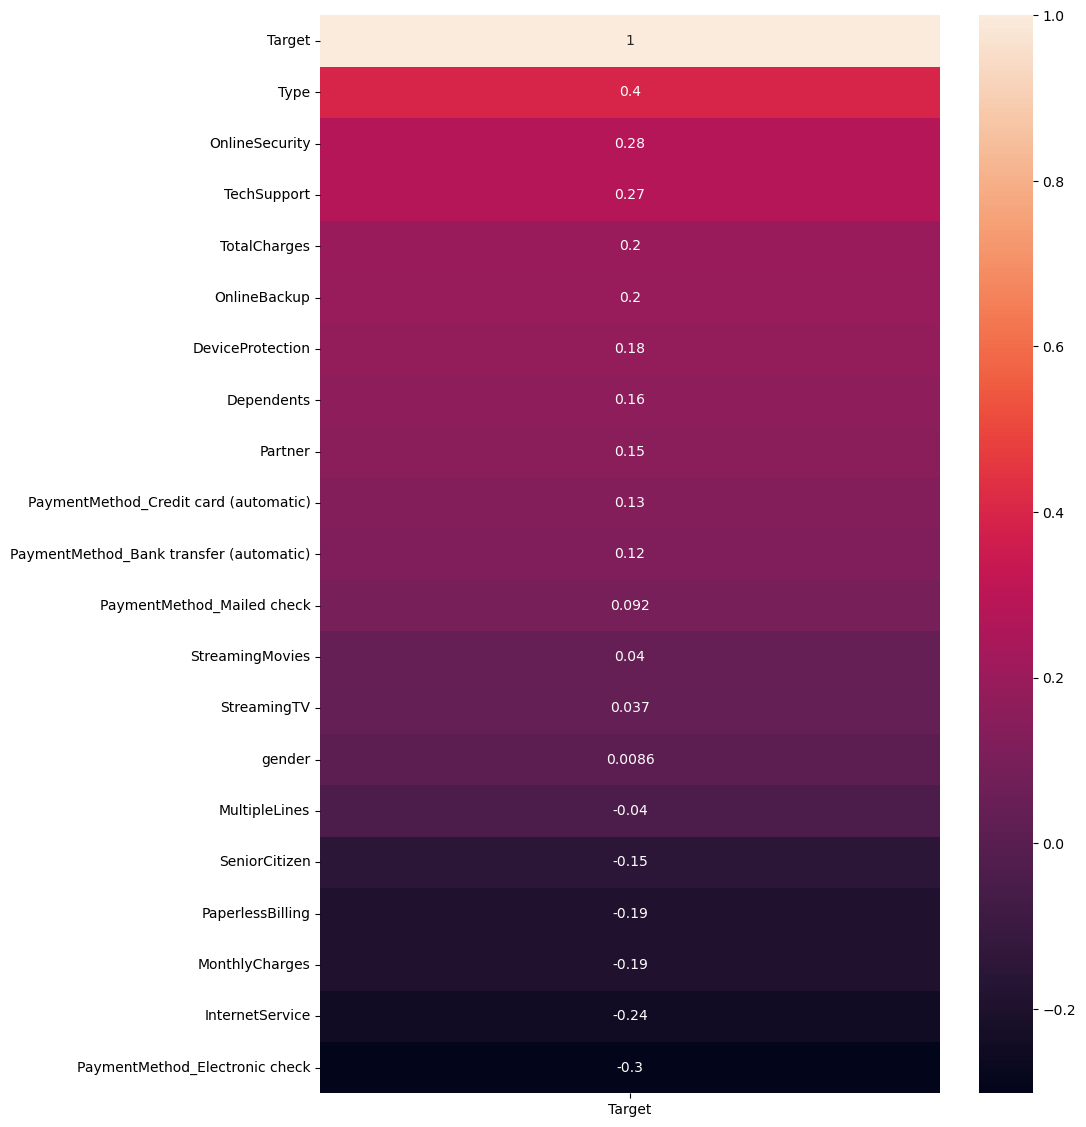

In [52]:
fig, ax = plt.subplots(figsize=(10,14))
saleprice_corr = merged_df.corr()[['Target']].sort_values(by='Target', ascending=False)
sns.heatmap(saleprice_corr, annot=True, ax=ax)
plt.show()

Created the churn column for our data set

In [53]:
merged_df["churn"] = (merged_df["EndDate"]!="No").astype("int")

Viewing the merged dataframe's new column of 'Churn'

In [54]:
merged_df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents,churn
0,7590-VHVEG,2020-01-01,No,0,1,29.85,29.85,0,0,1,...,0.0,0.0,0.0,0.0,NaN,0,0,1,0,0
1,5575-GNVDE,2017-04-01,No,1,0,56.95,1889.50,0,0,0,...,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,0,1,53.85,108.15,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1
3,7795-CFOCW,2016-05-01,No,1,0,42.30,1840.75,1,0,0,...,1.0,1.0,0.0,0.0,NaN,1,0,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,0,1,70.70,151.65,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1


Filled missing values into the columns with the number 0, specifying that these customers did not order the service that has a null value, for example multiple lines will now have a 0 where customers did not want that service.

In [55]:
merged_df = merged_df.fillna(0.0)

Created a countplot looking at the churn rate. Telecom has a lot more people staying subscribed than leaving but at a 2:5 ratio of leaving vs staying we need to figure out how to keep people subscribed and wanting to stay with the company. 

The graph also shows that we have and imbalance in the data and need to do some Upsampling to balance the data before testing

Text(0.5, 1.0, 'Subscribers vs Unsubscribed')

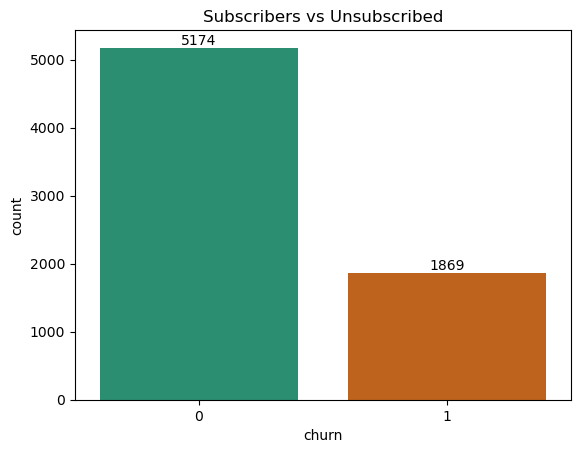

In [56]:
ax = sns.countplot(x='churn', data=merged_df, palette='Dark2')
ax.bar_label(ax.containers[0])
ax.set_title('Subscribers vs Unsubscribed')

In [57]:
merged_df_final = merged_df.drop(["customerID","BeginDate",	"EndDate"], axis=1)
merged_df_final.head()

,Type,PaperlessBilling,MonthlyCharges,TotalCharges,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Target,InternetService,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents,churn
0,0,1,29.85,29.85,0,0,1,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,1,0,0
1,1,0,56.95,1889.50,0,0,0,1,1,0.0,...,1.0,0.0,0.0,0.0,0.0,1,0,0,0,0
2,0,1,53.85,108.15,0,0,0,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1,0,0,0,1
3,1,0,42.30,1840.75,1,0,0,0,1,0.0,...,1.0,1.0,0.0,0.0,0.0,1,0,0,0,0
4,0,1,70.70,151.65,0,0,1,0,0,1.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1


Upsampling the data to handle the imbalance in our 'churn' column in the dataframe

In [58]:
# df_majority = merged_df_final[(merged_df_final['churn']==0)] 
# df_minority = merged_df_final[(merged_df_final['churn']==1)] 
# # upsample minority class
# df_minority_upsampled = resample(df_minority, 
#                                  replace=True,   
#                                  n_samples= 5174, 
#                                  random_state=1234)  

# df_upsampled = pd.concat([df_minority_upsampled, df_majority])

Upsampled Countplot showing that the upsampling was accomplished on the 'churn' column

In [60]:
# ax = sns.countplot(x='churn', data=df_upsampled, palette='PuBu')
# ax.bar_label(ax.containers[0])
# ax.set_title('Subscribers vs Unsubscribed')

Creating our Feature and Target values for our testing 

In [61]:
X = merged_df_final[['Type', 'PaperlessBilling', 'MonthlyCharges',
       'TotalCharges', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'MultipleLines', 'gender', 'SeniorCitizen', 'Partner', 'Dependents']]
y = merged_df_final['churn']

Performing SMOTE techniques on the data to deal with our class imbalance

In [62]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Perform oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

# Perform undersampling using RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Train the model on the oversampled dataset
model = RandomForestClassifier(random_state=42)
model.fit(X_train_oversampled, y_train_oversampled)

# Predict the target variable on the test set
y_pred = model.predict(X_test)

# Calculate the ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred)
print("ROC-AUC Score:", roc_auc)

ROC-AUC Score: 0.7118971710124524


Our Dummy Classifier does not have a better prediction rate than flipping a coin. 

In [82]:
dummy_model = DummyClassifier()
dummy_model.fit(X_train_oversampled, y_train_oversampled)
dummy_model.predict(X_test)
dummy_roc_auc = roc_auc_score(y_test, dummy_model.predict_proba(X_test)[:,1])
print(f"ROC AUC for our sample data is {round(roc_auc, 4)}")

ROC AUC for our sample data is 0.8468


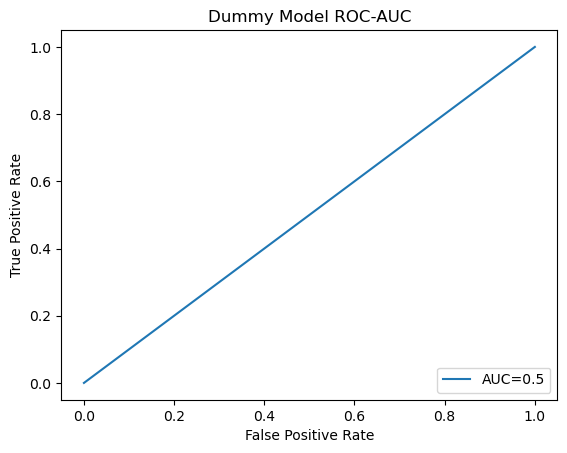

In [83]:
y_pred_proba = dummy_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title('Dummy Model ROC-AUC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Creating our linear regression model/dummy model to view our initial roc_auc_score.

In [142]:
lr_model = LogisticRegression(random_state=12345)
lr_model.fit(X_train_oversampled, y_train_oversampled)
y_pred = np.round(lr_model.predict(X_test), 3)
# roc_auc = roc_auc_score (y_test, y_pred)
log_roc_auc = roc_auc_score(y_test, lr_model.predict_proba(X_test)[:,1])
print(f"ROC AUC for our sample data is {round(log_roc_auc, 4)}")

ROC AUC for our sample data is 0.8196


Created an ROC graph showing the curve and calculated the Area under the curve, which is approximately 82% and since the curve hugs the top left corner of the plot, the better model does a decent job of classifying the data into categories.

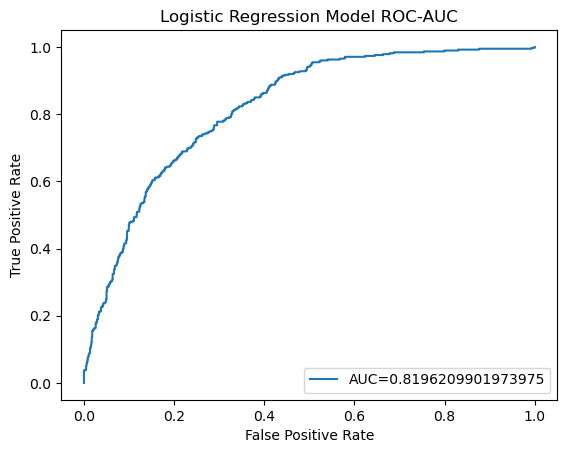

In [155]:
y_pred_proba = lr_model.predict_proba(X_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.title('Logistic Regression Model ROC-AUC')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Our XGB Model actually performed worse than our Logistic Regression Model at 80.49%. I am going to try and improve on this model because our models need to be performing better than our baseline.

In [144]:
xgb_model = XGBClassifier(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgb_model.fit(X_train_oversampled, y_train_oversampled)
xgb_pred = xgb_model.predict(X_test)
xgb_roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:,1])
print(f'RMSE XG Boost: {xgb_roc_auc}.')

RMSE XG Boost: 0.8048705062780129.


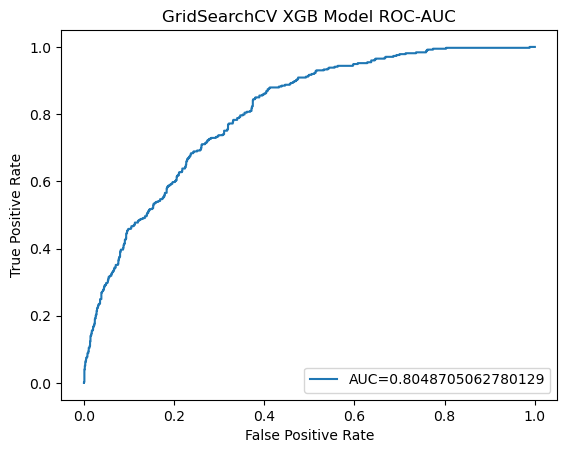

In [146]:
y_pred_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(xgb_roc_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('GridSearchCV XGB Model ROC-AUC')
plt.legend(loc=4)
plt.show()

Created a Catboost Model with GridSearch Cross Validation on the model. We input some parameters to try and help us find the best parameter for the model and we found that with a depth of 6 at 100 iterations and a learning rate of 0.1, this will give us our best score. The ROC-AUC score came out to 85.08%. 

In [111]:
param_grid =  {'depth'         : [6,8, 10],
               'learning_rate' : [0.1, 0.5],
               'iterations'    : [50, 100]
            }

catboostgs_model = CatBoostClassifier(verbose= False)

grid_search = GridSearchCV(catboostgs_model, param_grid, scoring='roc_auc')
grid_search.fit(X_train_oversampled, y_train_oversampled)

best_params = grid_search.best_params_
model = grid_search.best_estimator_
score = grid_search.best_score_
print('%s\tHP\t%s\t%f' % ("R" , str(best_params), abs(score)))

R	HP	{'depth': 6, 'iterations': 100, 'learning_rate': 0.1}	0.932929


This model is our second best performing model and can be used by the company to predict churn.

In [114]:
catboost_pred = grid_search.predict(X_test)
catboost_roc_auc = roc_auc_score(y_test, grid_search.predict_proba(X_test)[:,1])
print(f'ROC-AUC for our Catboost Model: {catboost_roc_auc}.')

ROC-AUC for our Catboost Model: 0.8508402600225656.


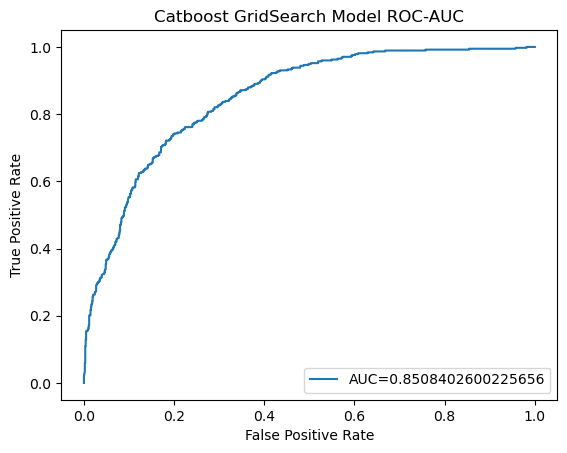

In [116]:
y_pred_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Catboost GridSearch Model ROC-AUC')
plt.legend(loc=4)
plt.show()

Creating a XGB DMatrix Model and input some parameters to try and best improve our score. The ROC-AUC score came out to 85.38%, which is our best score. The company can definitely use this model to predict churn with an 85% success rate. This can help the company retain customers by being able to make decisions to try and keep customers subscribed. 

In [147]:
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc', 
    'max_depth' : 5,
    'learning_rate' : 0.1,
}

dtrain = xgb.DMatrix(X_train, label=y_train)

model = xgb.train(params, dtrain)

dtest = xgb.DMatrix(X_test)

y_pred_prob = model.predict(dtest)

xgb_dmatrix_roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC-AUC score:", xgb_dmatrix_roc_auc)

ROC-AUC score: 0.8538434067924684


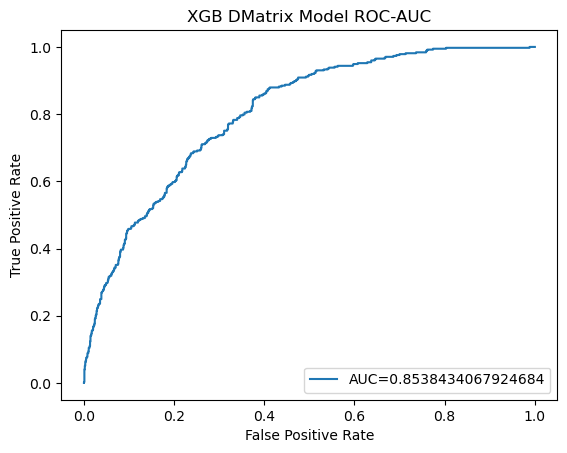

In [149]:
y_pred_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(xgb_dmatrix_roc_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('XGB DMatrix Model ROC-AUC')
plt.legend(loc=4)
plt.show()

Created a LightGBM Model and input some parameters to try and help us find the best parameter for the model and we found that with a depth of 3 is giving us the best score with a learning rate of 0.1. The result was an ROC-AUC Score that was extremely similar to the score we received with the XGB Model and the Catboost Model of 85.15 %. Either of these models seems to be great to use because they are all within some tenths of each other.

In [181]:
params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate' : 0.1,
    'max_depth' : 3,
    'random_state' : 123
}

# Convert the training data into LightGBM Dataset format
train_data = lgb.Dataset(X_train_oversampled, label=y_train_oversampled)

# Train the LightGBM model
lgb_model = lgb.train(params, train_data)

# Predict the probabilities on the test set
y_pred_prob = lgb_model.predict(X_test)

# Calculate the ROC-AUC score
lgb_roc_auc = roc_auc_score(y_test, y_pred_prob)

print("ROC-AUC score:", lgb_roc_auc)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 4138, number of negative: 4138
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2400
[LightGBM] [Info] Number of data points in the train set: 8276, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
ROC-AUC score: 0.8515454366660801


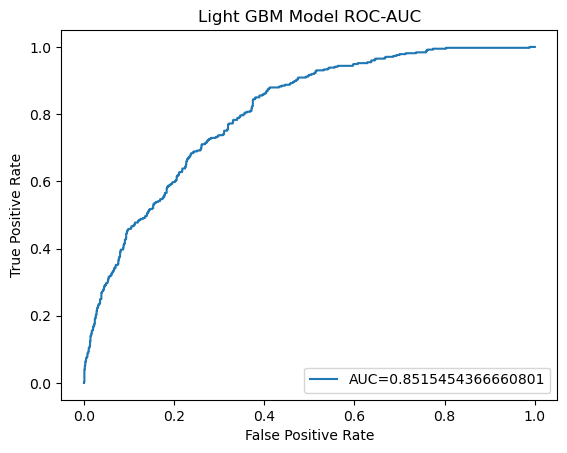

In [182]:
y_pred_proba = grid_search.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(lgb_roc_auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Light GBM Model ROC-AUC')
plt.legend(loc=4)
plt.show()

Created a Dataframe to show the models with the best ROC-AUC scores and to inform the company of which models that it should use. The company should be looking at the XGB DMatrix Model, the Light GBM Model, or the Catboost GridSearch Model when thinking about which to use for the churn problem that we are working to solve. 

In [183]:
# Dictionary of lists
models = ["Dummy Model", "Logistic Regression Model", "GridSearchCV XGB Model", 
          "Catboost GridSearch Model", "XGB DMatrix Model", "Light GBM Model"]
model_roc_auc = [dummy_roc_auc, log_roc_auc, xgb_roc_auc, 
                 catboost_roc_auc, xgb_dmatrix_roc_auc, lgb_roc_auc]

dict = {'Models': models,
        'ROC-AUC': model_roc_auc}
  
# Creating a dataframe from a dictionary 
model_df = pd.DataFrame(dict)
 
sorted_model_df = model_df.sort_values(by='ROC-AUC', ascending=False).reset_index(drop=True)
sorted_model_df

,Models,ROC-AUC
0,XGB DMatrix Model,0.853843
1,Light GBM Model,0.851545
2,Catboost GridSearch Model,0.850840
3,Logistic Regression Model,0.819621
4,GridSearchCV XGB Model,0.804871
5,Dummy Model,0.500000


# General Conclusion

For this project I began with reviewing the data and looking for interesting patterns. Then I did data transformation, processing, and analyzed different features. Finally, I looked at the tendency for customers to churn and created models to help predict when customers would churn. The model that came out to the best ROC-AUC Score is the XGBDMatrix Model with 85.38% and the Catboost GridSearch Model at 85.08%.  The company can now use these models in the future to predict whether a customer will churn or not. If the customer is predicted to churn, then we can take further steps to help and keep the customer subscribed to our services. 